### CONTENTS
#### 1 Importing Libraries
#### 2 Importing Data 
#### 3 Data wrangling
#### 4 Hyperparameter Optimization: Grid Search
##### 4.1 Grid Search
##### 4.2 Decision Tree Examples 
##### 4.3 Feature Importance Analysis
##### 4.4 Feature Importance (Weighted by Output Variance)
#### 5 Hyperparameter Optimization: Random Search
##### 5.1 Random Search
##### 5.2 Fitting Optimized Parameters


# 1 Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets  
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, classification_report
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn import metrics  
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.metrics import accuracy_score


In [100]:
import time
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

# 2 Importing Data

In [6]:
path = r'C:\Users\elena\Documents\06.2025 climatewins machine learning'

In [10]:
# Upload cleaned data

In [12]:
climate = pd.read_csv(os.path.join(path, '02 Data', 'Original data', 'Dataset-weather-prediction-dataset-processed.csv'), index_col = False)

In [14]:
climate.head()

DATE  MONTH  BASEL_cloud_cover  BASEL_wind_speed  BASEL_humidity  \
0  19600101      1                  7               2.1            0.85   
1  19600102      1                  6               2.1            0.84   
2  19600103      1                  8               2.1            0.90   
3  19600104      1                  3               2.1            0.92   
4  19600105      1                  6               2.1            0.95   

   BASEL_pressure  BASEL_global_radiation  BASEL_precipitation  \
0           1.018                    0.32                 0.09   
1           1.018                    0.36                 1.05   
2           1.018                    0.18                 0.30   
3           1.018                    0.58                 0.00   
4           1.018                    0.65                 0.14   

   BASEL_snow_depth  BASEL_sunshine  ...  VALENTIA_cloud_cover  \
0                 0             0.7  ...                     5   
1                 0             1.1  ...                     7   
2                 0             0.0  ...                     7   
3                 0             4.1  ...                     7   
4                 0             5.4  ...                     3   

   VALENTIA_humidity  VALENTIA_pressure  VALENTIA_global_radiation  \
0               0.88             1.0003                       0.45   
1               0.91             1.0007                       0.25   
2               0.91             1.0096                       0.17   
3               0.86             1.0184                       0.13   
4               0.80             1.0328                       0.46   

   VALENTIA_precipitation  VALENTIA_snow_depth  VALENTIA_sunshine  \
0                    0.34                    0                4.7   
1                    0.84                    0                0.7   
2                    0.08                    0                0.1   
3                    0.98                    0                0.0   
4                    0.00                    0                5.7   

   VALENTIA_temp_mean  VALENTIA_temp_min  VALENTIA_temp_max  
0                 8.5                6.0               10.9  
1                 8.9                5.6               12.1  
2                10.5                8.1               12.9  
3                 7.4                7.3               10.6  
4                 5.7                3.0                8.4  

[5 rows x 170 columns]

In [8]:
# Import the pleasant weather data.
pleasantweather = pd.read_csv(os.path.join(path, '02 Data', 'Original Data','Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'))

# 3 Data Wrangling

In [17]:
climate.columns

Index(['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_wind_speed',
       'BASEL_humidity', 'BASEL_pressure', 'BASEL_global_radiation',
       'BASEL_precipitation', 'BASEL_snow_depth', 'BASEL_sunshine',
       ...
       'VALENTIA_cloud_cover', 'VALENTIA_humidity', 'VALENTIA_pressure',
       'VALENTIA_global_radiation', 'VALENTIA_precipitation',
       'VALENTIA_snow_depth', 'VALENTIA_sunshine', 'VALENTIA_temp_mean',
       'VALENTIA_temp_min', 'VALENTIA_temp_max'],
      dtype='object', length=170)

In [19]:
# Drop weather stations for which pleasant/unpleasant classification is not available

In [21]:
cols_to_drop = [col for col in climate.columns if any(city in col for city in ['GDANSK', 'ROMA', 'TOURS'])]


In [23]:
climate = climate.drop(columns=cols_to_drop)

In [25]:
climate.shape

(22950, 149)

In [27]:
# Extract the different observation types

observation_types = ['cloud_cover', 'wind_speed', 'humidity', 'pressure',
                     'global_radiation', 'precipitation', 'snow_depth', 
                     'sunshine', 'temp_mean', 'temp_min', 'temp_max']

In [29]:
# Create a dictionary to store the count of stations for each observation type
station_counts = {}

for obs in observation_types:
    # Select columns related to the current observation type
    columns = [col for col in climate.columns if col.endswith(obs)]
    
    # Count the number of stations (i.e., the number of columns) for the current observation type
    station_counts[obs] = len(columns)

# Print the count of stations for each observation type
print("Number of stations covered by each observation type:")
for obs, count in station_counts.items():
    print(f"{obs}: {count} stations")

Number of stations covered by each observation type:
cloud_cover: 14 stations
wind_speed: 9 stations
humidity: 14 stations
pressure: 14 stations
global_radiation: 15 stations
precipitation: 15 stations
snow_depth: 6 stations
sunshine: 15 stations
temp_mean: 15 stations
temp_min: 15 stations
temp_max: 15 stations


Wind speed and snow depth data is missing for a number of stations, so will remove these factors.

In [32]:
# Get a list of columns containing 'wind_speed' or 'snow_depth'
cols_to_drop = [col for col in climate.columns if '_wind_speed' in col or '_snow_depth' in col]

# Drop the columns
climate = climate.drop(cols_to_drop, axis=1)

In [34]:
climate.shape

(22950, 134)

Data from one location is missing for the following observation types: cloud cover, humidity and pressure.
Need to find out which stations are missing a column

In [37]:
stationParameters = {}
allParameters = set()

pairs = [p.split('_', 1) for p in climate.columns]

for pair in pairs:
    if len(pair) < 2: continue
    if pair[0] not in stationParameters:
        stationParameters[pair[0]] = set()
    stationParameters[pair[0]].add(pair[1])
    allParameters.add(pair[1])

stationParameters.keys()

dict_keys(['BASEL', 'BELGRADE', 'BUDAPEST', 'DEBILT', 'DUSSELDORF', 'HEATHROW', 'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MADRID', 'MUNCHENB', 'OSLO', 'SONNBLICK', 'STOCKHOLM', 'VALENTIA'])

In [39]:
for station, parameters in stationParameters.items():
    if allParameters - parameters:
        print(station, "Missing:",  allParameters - parameters)

KASSEL Missing: {'cloud_cover'}
MUNCHENB Missing: {'pressure'}
STOCKHOLM Missing: {'humidity'}


In [41]:

# Create missing Kessel cloud cover and insert into the appropriate place.

In [43]:
# Step 1: Copy the column and assign to a new one
climate['KASSEL_cloud_cover'] = climate['LJUBLJANA_cloud_cover'].copy()

In [45]:
# Step 2: Get list of column names
cols = list(climate.columns)

# Step 3: Find index of the column *after which* to insert the new one
insert_after = 'HEATHROW_temp_max'
insert_at = cols.index(insert_after) + 1

# Step 4: Remove 'KASSEL_cloud_cover' from its current position (end of list)
cols.remove('KASSEL_cloud_cover')

# Step 5: Insert it at the desired position
cols.insert(insert_at, 'KASSEL_cloud_cover')

# Step 6: Reorder the DataFrame
climate = climate[cols]

In [47]:

# Create missing 'MUNCHENB_pressure' and insert after 'MUNCHENB_humidity'

In [49]:
# Step 1: Copy the column and assign to a new one
climate['MUNCHENB_pressure'] = climate['SONNBLICK_pressure'].copy()

In [51]:
# Step 2: Get list of column names
cols = list(climate.columns)

# Step 3: Find index of the column *after which* to insert the new one
insert_after = 'MUNCHENB_humidity'
insert_at = cols.index(insert_after) + 1

# Step 4: Remove 'MUNCHENB_pressure' from its current position (end of list)
cols.remove('MUNCHENB_pressure')

# Step 5: Insert it at the desired position
cols.insert(insert_at, 'MUNCHENB_pressure')

# Step 6: Reorder the DataFrame
climate = climate[cols]

In [53]:

# Create missing 'STOCKHOLM_humidity' and insert after STOCKHOLM_cloud_cover'

In [55]:
# Step 1: Copy the column and assign to a new one
climate['STOCKHOLM_humidity'] = climate['OSLO_humidity'].copy()

In [57]:
# Step 2: Get list of column names
cols = list(climate.columns)

# Step 3: Find index of the column *after which* to insert the new one
insert_after = 'STOCKHOLM_cloud_cover'
insert_at = cols.index(insert_after) + 1

# Step 4: Remove 'MUNCHENB_pressure' from its current position (end of list)
cols.remove('STOCKHOLM_humidity')

# Step 5: Insert it at the desired position
cols.insert(insert_at, 'STOCKHOLM_humidity')

# Step 6: Reorder the DataFrame
climate = climate[cols]

In [59]:
list(climate.columns)

['DATE',
 'MONTH',
 'BASEL_cloud_cover',
 'BASEL_humidity',
 'BASEL_pressure',
 'BASEL_global_radiation',
 'BASEL_precipitation',
 'BASEL_sunshine',
 'BASEL_temp_mean',
 'BASEL_temp_min',
 'BASEL_temp_max',
 'BELGRADE_cloud_cover',
 'BELGRADE_humidity',
 'BELGRADE_pressure',
 'BELGRADE_global_radiation',
 'BELGRADE_precipitation',
 'BELGRADE_sunshine',
 'BELGRADE_temp_mean',
 'BELGRADE_temp_min',
 'BELGRADE_temp_max',
 'BUDAPEST_cloud_cover',
 'BUDAPEST_humidity',
 'BUDAPEST_pressure',
 'BUDAPEST_global_radiation',
 'BUDAPEST_precipitation',
 'BUDAPEST_sunshine',
 'BUDAPEST_temp_mean',
 'BUDAPEST_temp_min',
 'BUDAPEST_temp_max',
 'DEBILT_cloud_cover',
 'DEBILT_humidity',
 'DEBILT_pressure',
 'DEBILT_global_radiation',
 'DEBILT_precipitation',
 'DEBILT_sunshine',
 'DEBILT_temp_mean',
 'DEBILT_temp_min',
 'DEBILT_temp_max',
 'DUSSELDORF_cloud_cover',
 'DUSSELDORF_humidity',
 'DUSSELDORF_pressure',
 'DUSSELDORF_global_radiation',
 'DUSSELDORF_precipitation',
 'DUSSELDORF_sunshine',
 'DUSS

In [61]:
climate.shape

(22950, 137)

In [63]:
pleasantweather.shape

(22950, 16)

In [65]:
# Select data for one decade, so the model doesn't run too long. Use the latest decade since the most recent data is likely to be the most accurate.

In [67]:
climate2010s = climate[
    (climate['DATE'].astype(str).str[:4] >= '2010') &
    (climate['DATE'].astype(str).str[:4] <= '2019')
]


In [69]:
climate2010s.head()

DATE  MONTH  BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  \
18263  20100101      1                  8            0.93          0.9965   
18264  20100102      1                  3            0.74          1.0193   
18265  20100103      1                  3            0.75          1.0226   
18266  20100104      1                  5            0.83          1.0169   
18267  20100105      1                  7            0.78          1.0073   

       BASEL_global_radiation  BASEL_precipitation  BASEL_sunshine  \
18263                    0.18                 0.56             0.0   
18264                    0.58                 0.00             5.2   
18265                    0.61                 0.00             6.3   
18266                    0.48                 0.00             3.7   
18267                    0.53                 0.04             4.4   

       BASEL_temp_mean  BASEL_temp_min  ...  STOCKHOLM_temp_max  \
18263              2.9            -0.2  ...                -7.0   
18264             -1.5            -4.2  ...                -7.1   
18265             -3.2            -6.0  ...                -7.1   
18266             -4.9            -8.3  ...                -3.6   
18267             -4.0            -7.1  ...                -5.5   

       VALENTIA_cloud_cover  VALENTIA_humidity  VALENTIA_pressure  \
18263                     1               0.80             1.0121   
18264                     1               0.82             1.0196   
18265                     4               0.71             1.0196   
18266                     2               0.67             1.0219   
18267                     4               0.78             1.0117   

       VALENTIA_global_radiation  VALENTIA_precipitation  VALENTIA_sunshine  \
18263                       0.43                    0.00                6.0   
18264                       0.45                    0.00                6.0   
18265                       0.36                    0.41                1.6   
18266                       0.48                    0.51                6.5   
18267                       0.45                    0.09                4.7   

       VALENTIA_temp_mean  VALENTIA_temp_min  VALENTIA_temp_max  
18263                 1.7               -1.6                5.0  
18264                 0.8               -4.5                6.2  
18265                 0.5               -4.1                5.1  
18266                 3.7                1.3                3.8  
18267                 2.3               -0.7                5.4  

[5 rows x 137 columns]

In [71]:
# Select wheather classifications for 2020s decade

In [73]:
pleasantweather2010s = pleasantweather[
    (pleasantweather['DATE'].astype(str).str[:4] >= '2010') &
    (pleasantweather['DATE'].astype(str).str[:4] <= '2019')
]

In [75]:
# Creating X data for analyses

In [77]:
X = climate2010s.drop(columns=['DATE', 'MONTH'])

In [79]:
# Creating y data for analyses. Need data from one 1 weather station.

In [81]:
y = pleasantweather2010s.drop(columns=['DATE'])

In [83]:
y.head()

BASEL_pleasant_weather  BELGRADE_pleasant_weather  \
18263                       0                          0   
18264                       0                          0   
18265                       0                          0   
18266                       0                          0   
18267                       0                          0   

       BUDAPEST_pleasant_weather  DEBILT_pleasant_weather  \
18263                          0                        0   
18264                          0                        0   
18265                          0                        0   
18266                          0                        0   
18267                          0                        0   

       DUSSELDORF_pleasant_weather  HEATHROW_pleasant_weather  \
18263                            0                          0   
18264                            0                          0   
18265                            0                          0   
18266                            0                          0   
18267                            0                          0   

       KASSEL_pleasant_weather  LJUBLJANA_pleasant_weather  \
18263                        0                           0   
18264                        0                           0   
18265                        0                           0   
18266                        0                           0   
18267                        0                           0   

       MAASTRICHT_pleasant_weather  MADRID_pleasant_weather  \
18263                            0                        0   
18264                            0                        0   
18265                            0                        0   
18266                            0                        0   
18267                            0                        0   

       MUNCHENB_pleasant_weather  OSLO_pleasant_weather  \
18263                          0                      0   
18264                          0                      0   
18265                          0                      0   
18266                          0                      0   
18267                          0                      0   

       SONNBLICK_pleasant_weather  STOCKHOLM_pleasant_weather  \
18263                           0                           0   
18264                           0                           0   
18265                           0                           0   
18266                           0                           0   
18267                           0                           0   

       VALENTIA_pleasant_weather  
18263                          0  
18264                          0  
18265                          0  
18266                          0  
18267                          0

In [85]:
X.shape

(3652, 135)

In [87]:
y.shape

(3652, 15)

In [89]:
# Turn X and y from a df to NumPy arrays

X = np.array(X)
y = np.array(y)

Data is ready for modeling

In [93]:
# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [95]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2739, 135) (2739, 15)
(913, 135) (913, 15)


# 4 Hyperparameter Optimization: Grid Search

## 4.1 Grid Search

In [108]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define your base classifier
base_clf = RandomForestClassifier(random_state=42)

In [110]:
# Wrap in MultiOutputClassifier
multi_clf = MultiOutputClassifier(base_clf, n_jobs=-1)

In [112]:
# Define parameter grid for the base classifier (RandomForest)
param_grid = {
    'estimator__n_estimators': [10, 100, 200],
    'estimator__max_depth': [3, 5, 10, None],
    'estimator__max_features': [15, 50, 100, 135],
    'estimator__min_samples_leaf': [1, 2, 3],
    'estimator__min_samples_split': [2, 3]  # must be ≥ 2
}


In [114]:
# Define scoring function
f1_micro_scorer = make_scorer(f1_score, average='micro')



In [116]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=multi_clf,
    param_grid=param_grid,
    scoring=f1_micro_scorer,  # or use average='macro'
    cv=3,
    verbose=3,
    n_jobs=-1
)

In [118]:
# Run grid search
start = time.time()
grid_search.fit(X_train, y_train)
end = time.time()

print("Best Parameters:", grid_search.best_params_)
print("Best Score (f1_micro):", grid_search.best_score_)
print("Grid search took %.2f minutes" % ((end - start)/60))

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best Parameters: {'estimator__max_depth': 3, 'estimator__max_features': 135, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 200}
Best Score (f1_micro): 0.9983855426746585
Grid search took 58.01 minutes


In [120]:
from sklearn.metrics import f1_score


In [122]:
# Best params from GridSearchCV
best_params = {
    'n_estimators': 200,
    'max_depth': 3,
    'max_features': 135,
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'random_state': 42
}


In [124]:
# Create base RF model with best params
rf_best = RandomForestClassifier(**best_params)


In [126]:
# Wrap in MultiOutputClassifier
multi_clf = MultiOutputClassifier(rf_best, n_jobs=-1)

In [128]:
# Train on training data
multi_clf.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=3,
                                                       max_features=135,
                                                       min_samples_leaf=2,
                                                       n_estimators=200,
                                                       random_state=42),
                      n_jobs=-1)

In [129]:
# Predict on test set
y_pred = multi_clf.predict(X_test)

In [132]:
# Evaluate
f1 = f1_score(y_test, y_pred, average='weighted')  # For multi-label/multi-output, may still warn
print(f"Weighted F1 Score (All stations): {f1:.4f}")

Weighted F1 Score (All stations): 0.9998


Model showed excellent performance. Better with the new optimized parameters than the previous version (weighted F1 was 0.9740)

## 4.2 Decision Tree Examples 

In [137]:
# Select the 1st output label (station 0), and 5th tree from its forest
one_tree = multi_clf.estimators_[0].estimators_[4]

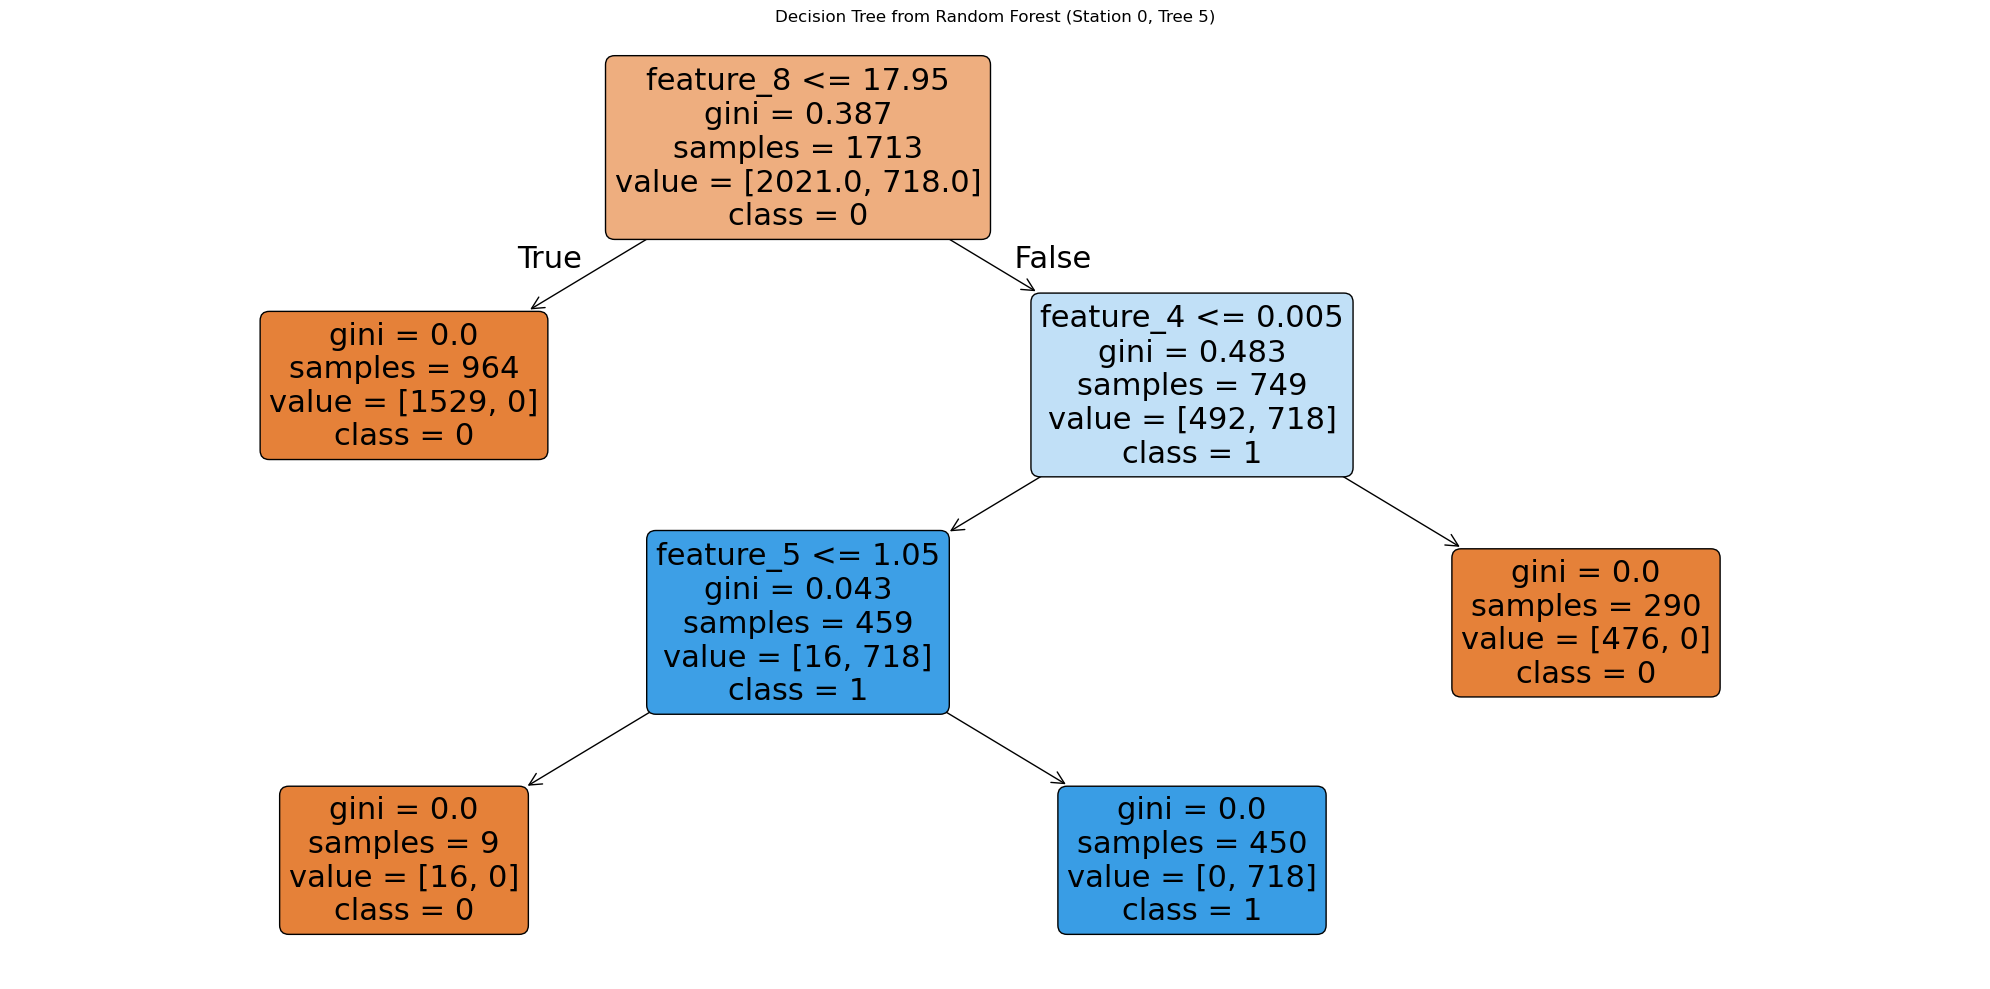

In [141]:
fig1 = plt.figure(figsize=(20, 10))
plot_tree(
    one_tree,
    filled=True,
    rounded=True,
    feature_names=[f'feature_{i}' for i in range(X.shape[1])],  # or use actual names if available
    class_names=['0', '1'],  # binary classes
    max_depth=3  # Optional: limit depth for readability
)
plt.title("Decision Tree from Random Forest (Station 0, Tree 5)")
plt.tight_layout()
plt.show()

In [143]:
fig1.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'grid_tree1.png'))

In [145]:
two_tree = multi_clf.estimators_[5].estimators_[10]

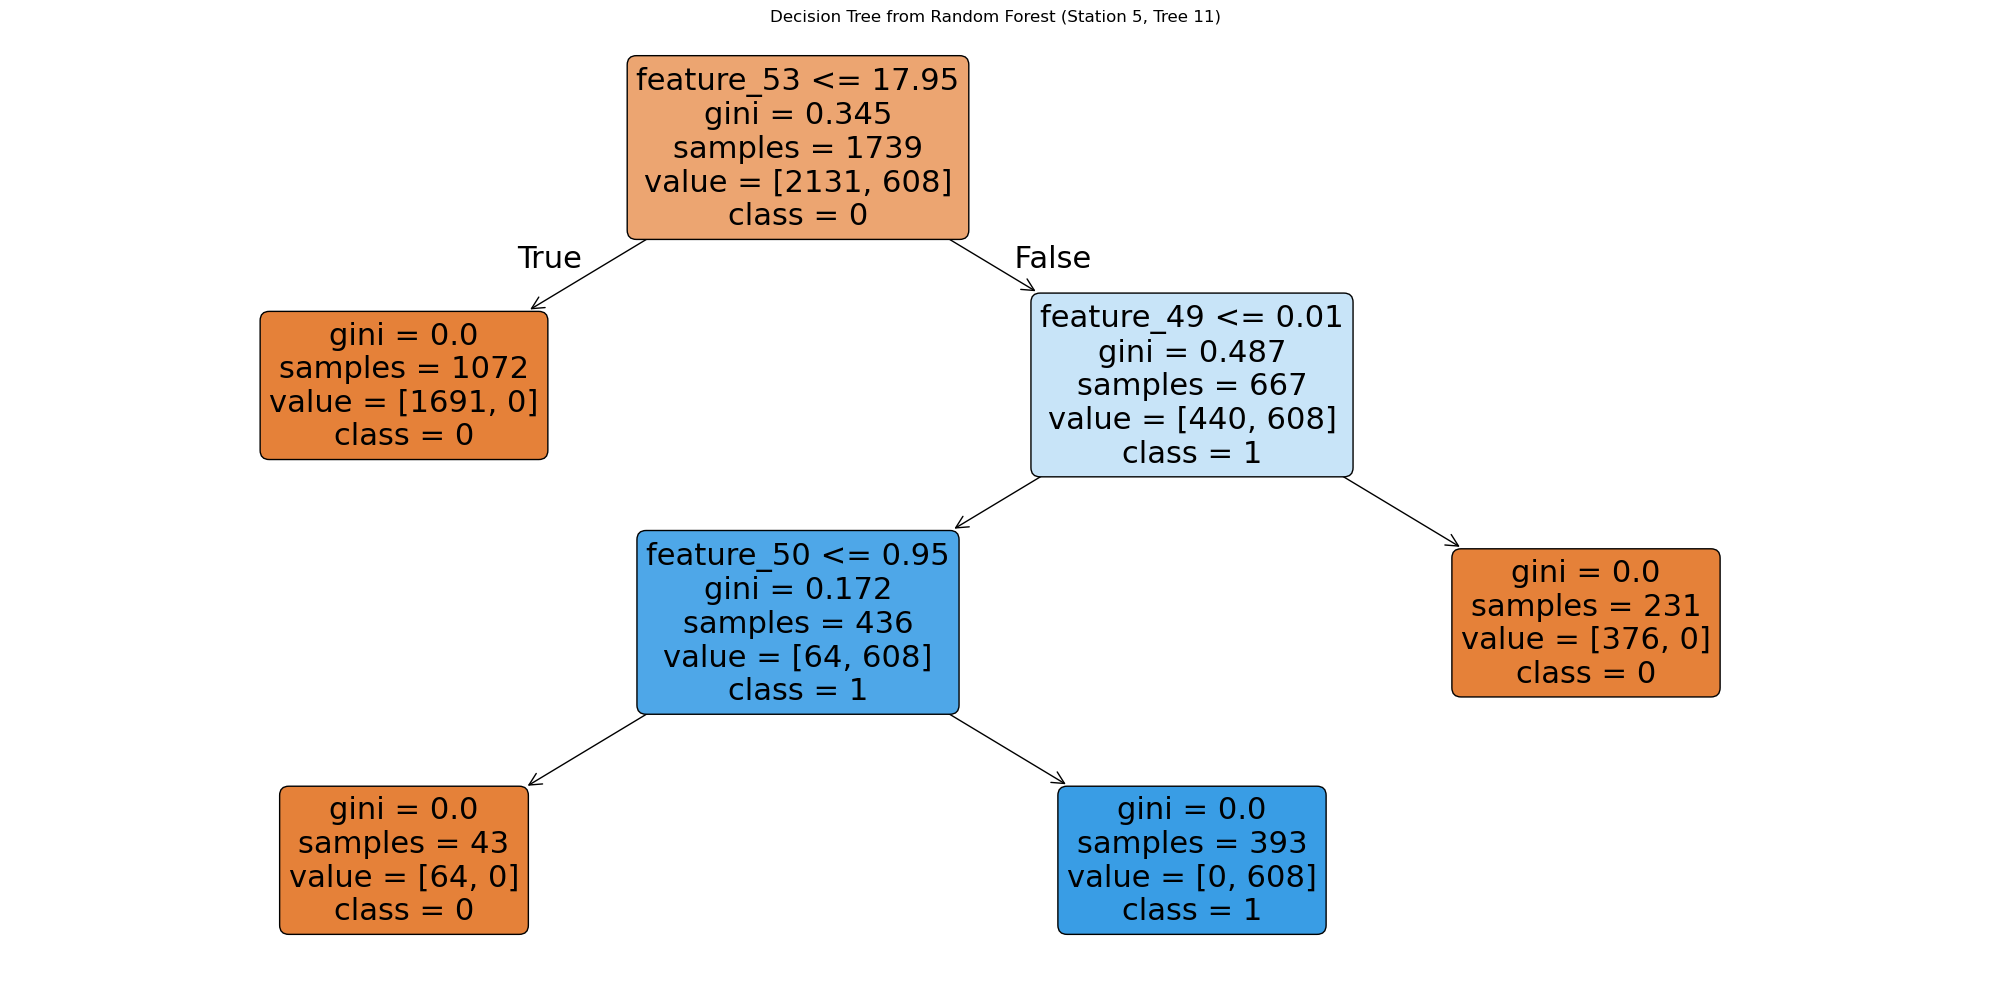

In [147]:
fig2 = plt.figure(figsize=(20, 10))
plot_tree(
    two_tree,
    filled=True,
    rounded=True,
    feature_names=[f'feature_{i}' for i in range(X.shape[1])],  # or use actual names if available
    class_names=['0', '1'],  # binary classes
    max_depth=3  # Optional: limit depth for readability
)
plt.title("Decision Tree from Random Forest (Station 5, Tree 11)")
plt.tight_layout()
plt.show()

In [149]:
fig2.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'grid_tree2.png'))

## 4.3 Feature Importance Analysis

In [154]:
# Step 1: Number of outputs and features
n_outputs = len(multi_clf.estimators_)       # 15 outputs (stations)
n_features = X_train.shape[1]                # 135 features

In [156]:
# Step 2: Get feature importances for each output classifier
feature_importances_all = np.array([
    est.feature_importances_ for est in multi_clf.estimators_
])  # shape = (15, 135)

In [158]:
# Step 3: Average importance across all outputs
avg_importance = np.mean(feature_importances_all, axis=0)  # shape = (135,)

In [160]:
# Step 4: Reshape into (15 stations × 9 features)
importance_per_station_feature = avg_importance.reshape(15, 9)

In [162]:
# Step 5: Sum across the 9 features per station
importance_per_station = importance_per_station_feature.sum(axis=1)  # shape = (15,)

In [164]:
# Step 6: Extract station names (from climate DataFrame)
feature_names = [col for col in climate.columns if col not in ['DATE', 'MONTH']]

In [166]:
station_names = []
for col in feature_names:
    station = col.split('_')[0]
    if station not in station_names:
        station_names.append(station)

In [168]:
# Step 7: Create DataFrame for plotting
df_importance = pd.DataFrame({
    'Weather Station': station_names,
    'Importance': importance_per_station
}).sort_values(by='Importance', ascending=False)

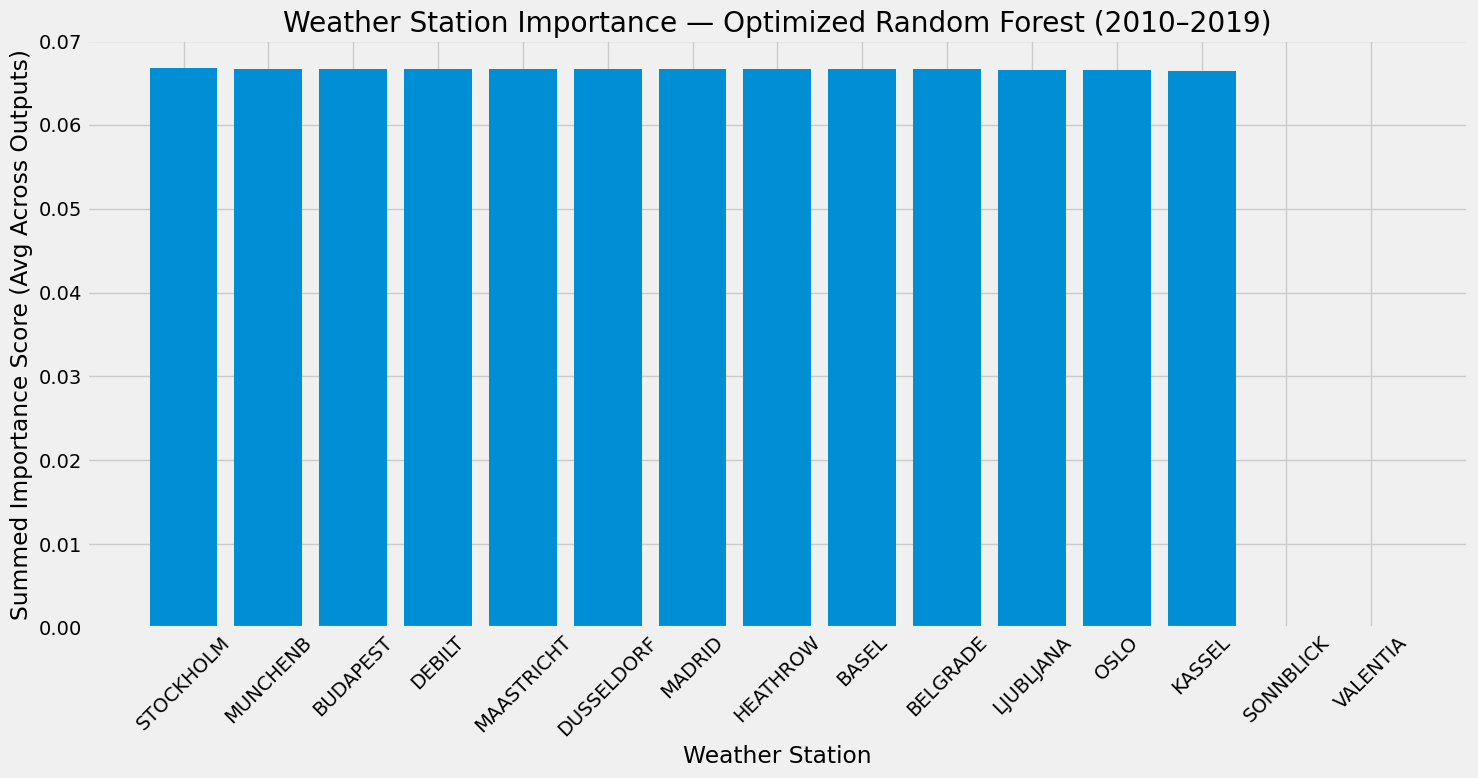

In [170]:
# Step 8: Plot
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 8))
plt.bar(df_importance['Weather Station'], df_importance['Importance'])
plt.xticks(rotation=45)
plt.xlabel('Weather Station')
plt.ylabel('Summed Importance Score (Avg Across Outputs)')
plt.title('Weather Station Importance — Optimized Random Forest (2010–2019)')
plt.tight_layout()
plt.show()

This is not very useful. I will try a different approach. 

## 4.4 Feature Importance (Weighted by Output Variance)

In [178]:
# Step 1: Compute variance of each output (15 stations)
variances = np.var(y_train, axis=0)  # shape = (15,)

In [180]:
# Step 2: Normalize variances to get weights
weights = variances / np.sum(variances)  # shape = (15,)

In [182]:
# Step 3: Get feature importances from each output's RF
feature_importances_all = np.array([
    est.feature_importances_ for est in multi_clf.estimators_
])  # shape = (15, 135)

In [184]:
# Step 4: Compute weighted average importance
weighted_avg_importance = np.average(feature_importances_all, axis=0, weights=weights)  # shape = (135,)

In [186]:
# Step 5: Reshape into (15 stations × 9 features)
importance_per_station_feature = weighted_avg_importance.reshape(15, 9)

In [188]:
# Step 6: Sum across 9 features per station
importance_per_station = importance_per_station_feature.sum(axis=1)  # shape = (15,)

In [190]:
# Step 7: Extract station names in correct order
feature_names = [col for col in climate.columns if col not in ['DATE', 'MONTH']]

station_names = []
for col in feature_names:
    station = col.split('_')[0]
    if station not in station_names:
        station_names.append(station)

In [192]:
# Step 8: Create DataFrame for plotting
df_importance = pd.DataFrame({
    'Weather Station': station_names,
    'Importance': importance_per_station
}).sort_values(by='Importance', ascending=False)

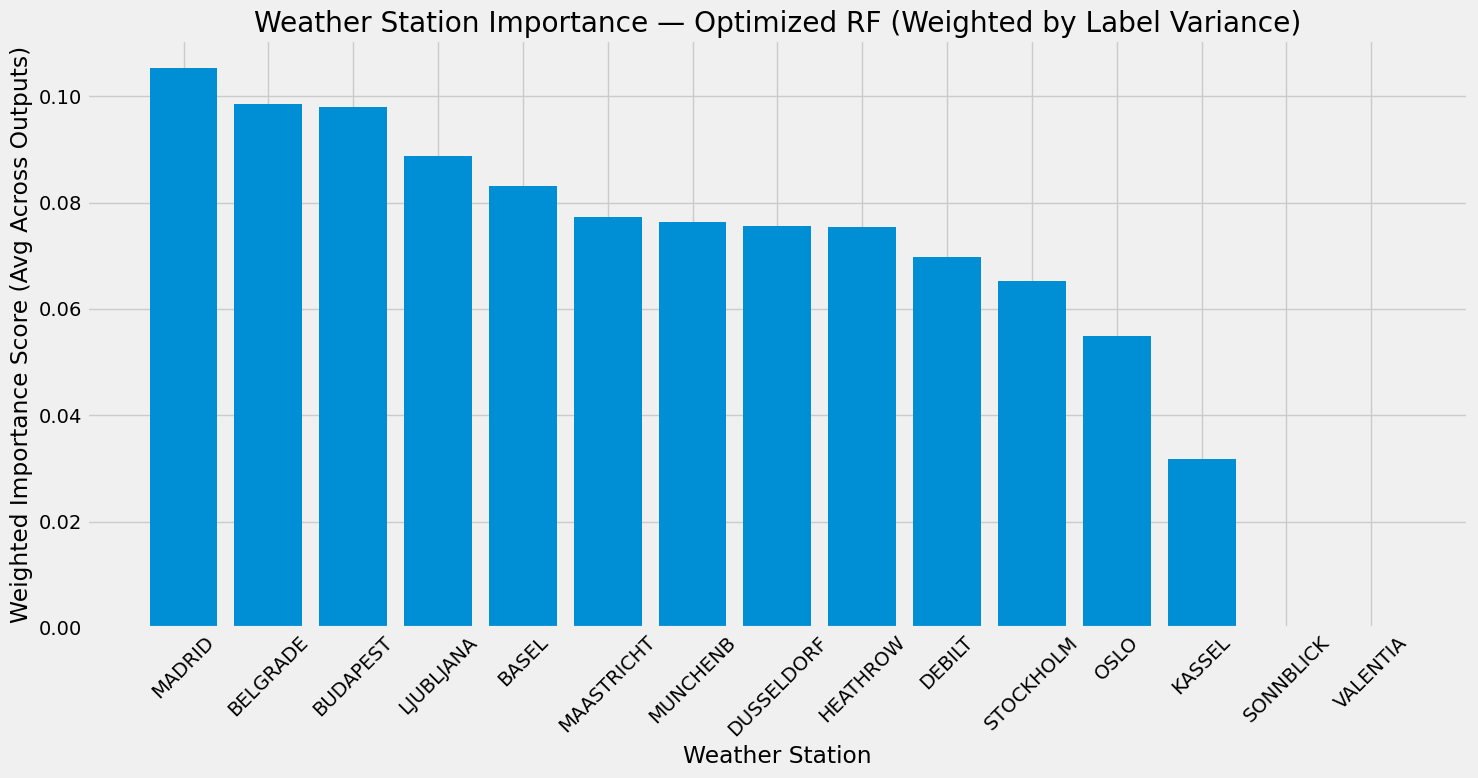

In [197]:
# Step 9: Plot
plt.style.use('fivethirtyeight')
fig3 = plt.figure(figsize=(15, 8))
plt.bar(df_importance['Weather Station'], df_importance['Importance'])
plt.xticks(rotation=45)
plt.xlabel('Weather Station')
plt.ylabel('Weighted Importance Score (Avg Across Outputs)')
plt.title('Weather Station Importance — Optimized RF (Weighted by Label Variance)')
plt.tight_layout()
plt.show()

This works much better. Now I can see that Madrid, Belgrade and Budapest contributed the most to classifications. I will perform random tree analyses on these weather stations to determine which weather features are most important. 

In [199]:
fig3.figure.savefig(os.path.join(path, '04 Analysis','Visualizations', 'station_importance_optimized.png'))

# 5 Hyperparameter Optimization: Random Search

Before moving on to analysing weather feature importance, I want to check if I would be able to achieve a similarly well-performing model with doing Random Search optimization.

## 5.1. Random Search

In [205]:
# Step 1: Create base Random Forest model
base_clf = RandomForestClassifier(random_state=42)


In [207]:
# Step 2: Wrap it in MultiOutputClassifier
multi_clf = MultiOutputClassifier(base_clf, n_jobs=-1)

In [209]:
# Step 3: Define random search parameter space
param_dist = {
    'estimator__n_estimators': [50, 100, 150, 200, 250],
    'estimator__max_depth': [3, 5, 10, 15, None],
    'estimator__max_features': [15, 50, 100, 135],
    'estimator__min_samples_leaf': [1, 2, 3, 5],
    'estimator__min_samples_split': [2, 3, 5]
}


In [211]:
# Step 4: Define weighted F1 scorer
f1_weighted_scorer = make_scorer(f1_score, average='weighted')

In [213]:
# Step 5: Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=multi_clf,
    param_distributions=param_dist,
    n_iter=30,  # You can adjust this to explore more or fewer combinations
    scoring=f1_weighted_scorer,
    cv=3,
    verbose=3,
    n_jobs=-1,
    random_state=42
)

In [216]:
# Step 6: Run the search
start = time.time()
random_search.fit(X_train, y_train)
end = time.time()


Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [218]:
# Step 7: Print results
print("Best Parameters (Random Search):", random_search.best_params_)
print("Best Weighted F1 Score (CV):", random_search.best_score_)
print("Random search took %.2f minutes" % ((end - start) / 60))

Best Parameters (Random Search): {'estimator__n_estimators': 250, 'estimator__min_samples_split': 2, 'estimator__min_samples_leaf': 2, 'estimator__max_features': 135, 'estimator__max_depth': 5}
Best Weighted F1 Score (CV): 0.9983153638201384
Random search took 6.86 minutes


The weighted F1 score is almost the same as after Grid Search (0.9983 compared to 0.9984). Let's try putting the optimized parameters into the random tree model to see if the weighter F1 on test data is as good as previously. 

## 5.2. Fitting Optimized Parameters

In [222]:
# Step 1: Get best parameters from RandomizedSearchCV
best_params = random_search.best_params_

In [224]:
# Step 2: Strip "estimator__" prefix
rf_params = {k.replace('estimator__', ''): v for k, v in best_params.items()}
rf_params['random_state'] = 42  # Ensure reproducibility

In [226]:
# Step 3: Create new model with best parameters
best_rf = RandomForestClassifier(**rf_params)
multi_rf = MultiOutputClassifier(best_rf, n_jobs=-1)


In [228]:
# Step 4: Fit model on training data
multi_rf.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=5,
                                                       max_features=135,
                                                       min_samples_leaf=2,
                                                       n_estimators=250,
                                                       random_state=42),
                      n_jobs=-1)

In [229]:
# Step 5: Predict on test set
y_pred = multi_rf.predict(X_test)


In [230]:
# Step 6: Evaluate using weighted F1 score
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 Score on Test Set: {f1_weighted:.4f}")

Weighted F1 Score on Test Set: 0.9998


The weighted F1 indicates that the model fit is just as good as with grid search optimization, while random search optimization took much less time! 